In [1]:
from lips import get_root_path
from lips.dataset import airfransDataSet
from lips.dataset.airfransDataSet import AirfRANSDataSet
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../../Airfrans/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","simulators","torch_fc.ini") #Configuration file re
# print(BENCH_CONFIG_PATH)

# Scalers
PRESS_SCALE = 1600.0
TURB_SCALE = 0.01
SPEED_SCALE = 75.0
DEFAULT_SCALE = 1.0


In [3]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

Loading dataset (task: reynolds, split: test): 100%|██████████| 496/496 [01:39<00:00,  4.99it/s]


In [4]:
print("train dataset: ", benchmark.train_dataset)

train dataset:  Instance of AirfRANSDataSet
Dataset name: train
	x-position
		 Data size: (18515415,)
	y-position
		 Data size: (18515415,)
	x-inlet_velocity
		 Data size: (18515415,)
	y-inlet_velocity
		 Data size: (18515415,)
	distance_function
		 Data size: (18515415,)
	x-normals
		 Data size: (18515415,)
	y-normals
		 Data size: (18515415,)
	x-velocity
		 Data size: (18515415,)
	y-velocity
		 Data size: (18515415,)
	pressure
		 Data size: (18515415,)
	turbulent_viscosity
		 Data size: (18515415,)



In [5]:
print(benchmark.train_dataset.extra_data['simulation_names'])

[['airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078' '170180']
 ['airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882' '179653']
 ['airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763' '184381']
 ['airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866' '177944']
 ['airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137' '178145']
 ['airFoil2D_SST_66.028_3.694_1.787_7.157_1.0_8.637' '178100']
 ['airFoil2D_SST_60.333_1.218_3.932_7.599_1.0_9.745' '174285']
 ['airFoil2D_SST_72.844_3.105_2.426_4.619_19.695' '174181']
 ['airFoil2D_SST_66.62_-0.743_0.839_4.397_14.875' '178475']
 ['airFoil2D_SST_74.539_-1.677_1.68_5.819_1.0_12.084' '180950']
 ['airFoil2D_SST_75.517_-3.634_1.762_7.071_1.0_17.343' '178007']
 ['airFoil2D_SST_58.363_5.802_5.647_2.966_16.926' '178919']
 ['airFoil2D_SST_73.976_-2.934_2.212_6.681_0.0_13.706' '179267']
 ['airFoil2D_SST_67.701_0.938_6.996_0.0_15.872' '180891']
 ['airFoil2D_SST_53.127_-0.9_3.678_4.25_0.0_19.817' '185397']
 ['airFoil2D_SST_57.861_12.67_1.489_5.729_0.0_7.279' '182362']
 ['air

In [6]:
def extract_dataset_by_simulation(newdataset_name:str,
                                   dataset:AirfRANSDataSet,
                                   simulation_index:int):
    simulation_sizes = dataset.get_simulations_sizes()
    sample_sizes = [None]*len(simulation_sizes)
    start_index = 0
    for simulation_Id,simulation_size in enumerate(simulation_sizes):
        sample_sizes[simulation_Id] = range(start_index,start_index+simulation_size)
        start_index+= simulation_size
    # values=operator.itemgetter(*list(simulation_indices))(sample_sizes)
    nodes_simulation_indices = sorted([item for sublist in [sample_sizes[simulation_index]] for item in sublist])

    new_data={}
    for data_name in dataset._attr_names:
        new_data[data_name]=dataset.data[data_name][nodes_simulation_indices]
    new_extra_data={
                    'simulation_names':dataset.extra_data['simulation_names'][simulation_index],
                    'surface':dataset.extra_data['surface'][nodes_simulation_indices]
                    }
    new_dataset=type(dataset)(config = dataset.config, 
                             name = newdataset_name,
                             task = dataset._task,
                             split = dataset._split,
                             attr_names = dataset._attr_names, 
                             attr_x = dataset._attr_x , 
                             attr_y = dataset._attr_y)

    new_dataset.data=new_data
    new_dataset.extra_data=new_extra_data
    new_dataset._infer_sizes()
    return new_dataset




In [7]:
# def translate(point, new_origin):
#     return point - new_origin

# def untranslate(point, old_origin):
#     return point + old_origin

# def project(point, line_vector):
#     return line_vector * (line_vector.dot(point) / line_vector.dot(line_vector))

# def rotate_deg(point, degrees):
#     rads = degrees * np.pi/180
#     rot_matrix = np.array([[np.cos(rads), -np.sin(rads)],[np.sin(rads), np.cos(rads)]])
#     return rot_matrix.dot(point)

def expand(vector):
    if vector.ndim == 1:
        out = np.expand_dims(vector, 0)
        return np.copy(out), True
    else:
        return np.copy(vector), False

def rotate(point, angle):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    return point.dot(rot_matrix)

def angle_between(a, b):
    if a.ndim == 1 and b.ndim == 1:
        assert(np.linalg.norm(a) > 0 and np.linalg.norm(b) > 0)
        theta = np.arccos(np.maximum(-1, np.minimum(1, a.dot(b)/np.linalg.norm(a)/np.linalg.norm(b))))
    else:
        assert(a.ndim == 1)
        np.seterr(all='raise')
        theta = np.arccos(np.maximum(-1, np.minimum(1, b.dot(a)/np.linalg.norm(a)/np.linalg.norm(b, axis=1))))
    return theta

def distance(a, b):
    return np.linalg.norm(a-b)

def relative_wind_angle(vector):
    vector, expanded = expand(vector)
    vel_theta = angle_between(np.array([1,0]), vector)
    vel_theta, _ = expand(vel_theta)
    vel_theta[np.where(vel_theta < 0)] *= -1
    if expanded:
        vel_theta = vel_theta.squeeze()
    return vel_theta

def rotate_normal(vector):
    if vector[1] <= 0: # Rotate 90 degrees counterclockwise
        out_vector = rotate(vector, -np.pi/2)
    else: #Clockwise
        out_vector = rotate(vector, np.pi/2)
    return out_vector


# def in_cone(point, origin, vector, tolerance_deg):
#     trans = translate(point, origin)
#     val = angle_between(trans, vector) <= (tolerance_deg * np.pi/360)
#     # print(val)
#     return val

# forty_five_north = np.array([-np.cos(np.pi/4), np.sin(np.pi/4)])

# print(in_cone(key_point + np.array([-.8, .7]), key_point, forty_five_north, 5))

# plt.figure()
# plt.scatter(0, 0, c='#0000DD', marker='x')
# plt.scatter(translate(test_point, key_point)[0], translate(test_point, key_point)[1], c='#0000DD', marker='o')
# plt.scatter(project(translate(test_point, key_point), forty_five_north)[0], project(translate(test_point, key_point), forty_five_north)[1], c='#0000DD', marker='x')
# plt.xlim([-1.5, 1.5])
# plt.ylim([-1.5, 1.5])
# plt.show()


In [8]:

def find_parents(idx, data, start_min, degree_list, tolerance):
    key_point = data[idx,:2] # Point of interest
    comps_mod = data[start_min:idx, :2] - key_point # Translated comparision points
    norms = comps_mod / np.expand_dims(np.linalg.norm(comps_mod, axis=1),1) # Unit vectors for comparison points

    ret_idx = []
    for degree in degree_list:
        vector = np.array([np.cos(degree * np.pi/180), np.sin(degree * np.pi/180)]) # Vector to look for parents
        thetas = np.arccos(np.maximum(-1, np.minimum(1, norms.dot(vector)))) # Find angles for all comparison points
        matching = np.argwhere(thetas <= (tolerance * np.pi/360)) # Filter by tolerance range
        c = np.atleast_1d(comps_mod[matching.squeeze(axis=1), :2].squeeze().dot(vector)) # Project onto the vector
        if(len(c) == 0): # We don't find any possible matches, then handle it
            if abs(key_point[1]) <= 1 and key_point[0] >= -1 and key_point[0] <= 2: # If we are close to the airfoil
                ret_idx.append(-2) # Close to airfoil
                continue
            else:
                ret_idx.append(-1) # Close to edge
                continue
        best = matching[np.argmin(c[np.argwhere(c>0)])] + start_min # Find index of the closest projected point
        ret_idx.append(best.item()) # Append to our return values
    return ret_idx


In [9]:

# ('x-position', 'y-position', 'x-inlet_velocity', 'y-inlet_velocity', 'distance_function', 'x-normals', 'y-normals')
# ('x-velocity', 'y-velocity', 'pressure', 'turbulent_viscosity')

# Create friendly index headers
X = 0
Y = 1
X_INLET = 2
Y_INLET = 3
DIST = 4
X_NORMAL = 5
Y_NORMAL = 6
X_VEL = 7
Y_VEL = 8
PRESS = 9
TURB = 10

def transform_x(idx, data, parents, surface, speed, theta):
    features = []
    line = data[idx, :]

    # Find closest surface point
    if line[X_NORMAL] != 0 or line[Y_NORMAL] != 0:
        closest = line
    else:
        closest = surface[np.argmin(np.linalg.norm(surface[:,:2] - line[:2], axis=1))]

    # Create modified angles and flow metrics
    surface_flow = rotate_normal(closest[X_NORMAL:Y_NORMAL+1])
    surface_theta = relative_wind_angle(surface_flow).item()

    features.append(line[X])
    features.append(line[Y])
    features.append(speed / SPEED_SCALE)
    features.append(theta)
    features.append(line[DIST])
    features.append(surface_theta)
    for parent in parents[idx]:
        if parent == -1: # Off the grid
            features.append(line[X])
            features.append(line[Y])
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(-1.0) # Off the grid specifier
        elif parent == -2: # Airfoil interior
            features.append(line[X])
            features.append(line[Y])
            features.append(0.0)
            features.append(0.0)
            features.append(surface_theta)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(1.0) # Interior specifier
        else:
            p = data[parent, :]
            if p[Y_NORMAL] != 0 or p[X_NORMAL] != 0: # Surface node
                features.append(p[X]) #1 X
                features.append(p[Y]) #2 Y
                features.append(0.0) #3 Distance (zero for surface)
                features.append(distance(p[X:Y+1], line[X:Y+1])) #4 Dist to parent

                p_flow = rotate_normal(p[X_NORMAL:Y_NORMAL+1])
                p_theta = relative_wind_angle(p_flow)

                features.append(p_theta) #5 Parent normal theta
                features.append(0.0) #6 Vel theta
                features.append(0.0) #7 Speed
                features.append(p[PRESS] / PRESS_SCALE) #8 Pressure
                features.append(p[TURB] / TURB_SCALE) #9 Turbulence - none for airfoil
                features.append(1.0) #10 Surface specifier
            else:
                features.append(p[X]) #1
                features.append(p[Y]) #2
                features.append(p[DIST]) #3
                features.append(distance(p[X:Y+1], line[X:Y+1])) #4

                vel_theta = relative_wind_angle(p[X_VEL:Y_VEL+1]).item()
                p_speed = np.linalg.norm(p[X_VEL:Y_VEL+1]) / SPEED_SCALE

                features.append(0.0) #5 Parent normal theta
                # features.append(vel_theta) #6 Vel theta
                # features.append(p_speed) #7 Speed
                features.append(p[X_VEL] / SPEED_SCALE)
                features.append(p[Y_VEL] / SPEED_SCALE)
                features.append(p[PRESS] / PRESS_SCALE) #8 Pressure
                features.append(p[TURB] / TURB_SCALE) #9 Turbulence
                features.append(0.0) #10 Normal specifier

    return np.array(features)


def transform_y(y_set, surface_indices):
    out, expanded = expand(y_set)
    y_set, _ = expand(y_set)
    # if True in surface_indices:
    #     out[np.array(surface_indices), 0] = 0.0
    # out[~np.array(surface_indices), 0] = relative_wind_angle(out[~np.array(surface_indices), 0:2])
    
    # out[:, 1] = np.linalg.norm(y_set[:, 0:2], axis=1) / SPEED_SCALE
    out[:, 0] /= SPEED_SCALE
    out[:, 1] /= SPEED_SCALE
    out[:, 2] /= PRESS_SCALE
    out[:, 3] /= TURB_SCALE
    if expanded:
        out = out.squeeze()
    return out

def untransform_y(y_preds):
    out, expanded = expand(y_preds)
    y_preds, _ = expand(y_preds)
    # out[:, 0] = np.cos(y_preds[:, 0]) * y_preds[:, 1] * SPEED_SCALE # X-vec * speed
    # out[:, 1] = np.sin(y_preds[:, 0]) * y_preds[:, 1] * SPEED_SCALE # X-vec * speed
    out[:, 0] *= SPEED_SCALE
    out[:, 1] *= SPEED_SCALE
    out[:, 2] *= PRESS_SCALE
    out[:, 3] *= TURB_SCALE
    if expanded:
        out = out.squeeze()
    return out



In [10]:

def extract_and_realign(dataset, sim):
    print("Simulation: " + str(sim))
    data_by_sim = extract_dataset_by_simulation("BySim", benchmark.train_dataset, sim)
    x, y = data_by_sim.extract_data()
    data = np.hstack((x, y))
    data = data[data[:, 0].argsort()]

    # Rotate data based on inlet velocity
    in_vector = np.copy(data[0,X_INLET:Y_INLET+1]) # Get inlet velocity vector
    speed = np.linalg.norm(in_vector) # Get inlet speed
    in_vector /= speed # Normalize inlet velocity vector

    theta = np.arccos(np.maximum(-1, np.minimum(1,np.array([1,0]).dot(in_vector)))) # Wind theta
    if(in_vector[1] < 0): # Rotate counterclockwise if y_vector below 0
        theta = -theta

    data[:,:2] = rotate(data[:,:2], theta)
    data[:,X_NORMAL:Y_NORMAL+1] = rotate(data[:,X_NORMAL:Y_NORMAL+1], theta)
    data[:,X_VEL:Y_VEL+1] = rotate(data[:,X_VEL:Y_VEL+1], theta) # Now have rotated velocity vectors 

    return data, speed, theta

def identify_parents(data, sim):
    # Find parent relationships
    if os.path.exists('parents_' + str(sim) + '.npy'):
        parents = np.load('parents_' + str(sim) + '.npy')
    else:
        min_search = 0
        parents = []
        for i in tqdm(range(0, data.shape[0])):
            for m in range(min_search, i, 100):
                if data[i, 0] - data[m, 0] > .3: # Truncate search space for speed
                    min_search += 100
            parents.append(find_parents(i, data, min_search, [180, 135, 225], 5))
        np.save('parents_' + str(sim) + '.npy', np.array([np.array(xi) for xi in parents]))
    return parents

def get_surface(data):
    return data[np.where(np.logical_or(data[:,X_NORMAL] != 0.0, data[:,Y_NORMAL] != 0.0))]


In [12]:
# Collect training examples and build features

train_x = []
train_y = []
train_x_raw = []
train_y_raw = []

def is_surface(row):
    return row[X_NORMAL] != 0.0 or row[Y_NORMAL] != 0.0

for sim in range(0, 50):    
    data, speed, theta = extract_and_realign(benchmark.train_dataset, sim)
    parents = identify_parents(data, sim)
    surface = get_surface(data)

    # Build train data
    for idx in tqdm(range(0, len(data))):
        train_x.append(transform_x(idx, data, parents, surface, speed, theta))
        # train_x_raw.append(data[idx,:])
        train_y.append(transform_y(data[idx, X_VEL:], [is_surface(data[idx])]))    
        # train_y_raw.append(data[idx, X_VEL:])

print(len(train_x))
train_x = np.vstack(train_x)
# train_x_raw = np.vstack(train_x_raw)
train_y = np.vstack(train_y)
# train_y_raw = np.vstack(train_y_raw)

Simulation: 0


100%|██████████| 170180/170180 [00:41<00:00, 4127.99it/s]


Simulation: 1


100%|██████████| 179653/179653 [00:42<00:00, 4250.09it/s]


Simulation: 2


100%|██████████| 184381/184381 [00:45<00:00, 4027.11it/s]


Simulation: 3


100%|██████████| 177944/177944 [00:41<00:00, 4246.88it/s]


Simulation: 4


100%|██████████| 178145/178145 [00:41<00:00, 4320.37it/s] 


Simulation: 5


100%|██████████| 178100/178100 [00:44<00:00, 3996.80it/s]


Simulation: 6


100%|██████████| 174285/174285 [00:39<00:00, 4439.00it/s]


Simulation: 7


100%|██████████| 174181/174181 [00:40<00:00, 4305.99it/s]


Simulation: 8


100%|██████████| 178475/178475 [00:42<00:00, 4207.59it/s]


Simulation: 9


100%|██████████| 180950/180950 [00:24<00:00, 7278.08it/s]


Simulation: 10


100%|██████████| 178007/178007 [00:20<00:00, 8861.83it/s]


Simulation: 11


100%|██████████| 178919/178919 [00:19<00:00, 9132.72it/s] 


Simulation: 12


100%|██████████| 179267/179267 [00:20<00:00, 8874.97it/s]


Simulation: 13


100%|██████████| 180891/180891 [00:20<00:00, 8860.53it/s]


Simulation: 14


100%|██████████| 185397/185397 [00:21<00:00, 8798.40it/s]


Simulation: 15


100%|██████████| 182362/182362 [00:12<00:00, 14092.75it/s]


Simulation: 16


100%|██████████| 162377/162377 [00:17<00:00, 9043.79it/s] 


Simulation: 17


100%|██████████| 187472/187472 [00:20<00:00, 9058.10it/s] 


Simulation: 18


100%|██████████| 180434/180434 [00:20<00:00, 8894.46it/s]


Simulation: 19


100%|██████████| 180122/180122 [00:14<00:00, 12275.53it/s]


Simulation: 20


100%|██████████| 182184/182184 [00:20<00:00, 8933.98it/s]


Simulation: 21


100%|██████████| 168944/168944 [00:16<00:00, 10116.89it/s]


Simulation: 22


100%|██████████| 179615/179615 [00:19<00:00, 9099.98it/s]


Simulation: 23


100%|██████████| 179748/179748 [00:20<00:00, 8950.95it/s]


Simulation: 24


100%|██████████| 173520/173520 [00:19<00:00, 8809.51it/s]


Simulation: 25


100%|██████████| 182130/182130 [00:20<00:00, 8841.21it/s]


Simulation: 26


100%|██████████| 181379/181379 [00:20<00:00, 8844.47it/s]


Simulation: 27


100%|██████████| 185801/185801 [00:21<00:00, 8790.96it/s]


Simulation: 28


100%|██████████| 158768/158768 [00:12<00:00, 12436.34it/s]


Simulation: 29


100%|██████████| 179617/179617 [00:17<00:00, 10537.87it/s]


Simulation: 30


100%|██████████| 167313/167313 [00:18<00:00, 8855.46it/s]


Simulation: 31


100%|██████████| 182017/182017 [00:12<00:00, 14991.55it/s]


Simulation: 32


100%|██████████| 179388/179388 [00:16<00:00, 10762.30it/s]


Simulation: 33


100%|██████████| 179877/179877 [00:14<00:00, 12071.57it/s]


Simulation: 34


100%|██████████| 181559/181559 [00:19<00:00, 9437.62it/s] 


Simulation: 35


100%|██████████| 182548/182548 [00:20<00:00, 8933.67it/s] 


Simulation: 36


100%|██████████| 178486/178486 [00:12<00:00, 14098.17it/s]


Simulation: 37


100%|██████████| 180428/180428 [00:20<00:00, 8926.36it/s] 


Simulation: 38


100%|██████████| 193096/193096 [00:22<00:00, 8717.63it/s]


Simulation: 39


100%|██████████| 181419/181419 [00:20<00:00, 8798.98it/s]


Simulation: 40


100%|██████████| 183097/183097 [00:18<00:00, 9893.95it/s] 


Simulation: 41


100%|██████████| 185552/185552 [00:21<00:00, 8798.89it/s]


Simulation: 42


100%|██████████| 160273/160273 [00:17<00:00, 9394.85it/s] 


Simulation: 43


100%|██████████| 182817/182817 [00:20<00:00, 8877.11it/s]


Simulation: 44


100%|██████████| 179479/179479 [00:20<00:00, 8930.20it/s]


Simulation: 45


100%|██████████| 183883/183883 [00:20<00:00, 8919.49it/s]


Simulation: 46


100%|██████████| 185794/185794 [00:12<00:00, 14745.26it/s]


Simulation: 47


100%|██████████| 180435/180435 [00:20<00:00, 8819.19it/s]


Simulation: 48


100%|██████████| 180599/180599 [00:12<00:00, 14560.43it/s]


Simulation: 49


100%|██████████| 180442/180442 [00:16<00:00, 11076.72it/s]


8951750


In [363]:
# train_x = np.vstack(train_x)
# # train_x_raw = np.vstack(train_x_raw)
# train_y = np.vstack(train_y)
# # train_y_raw = np.vstack(train_y_raw)
train_y.shape

(8951750, 4)

In [13]:
mdl_vel_theta = xgb.XGBRegressor()
mdl_speed = xgb.XGBRegressor()
mdl_x = xgb.XGBRegressor()
mdl_y = xgb.XGBRegressor()
mdl_press = xgb.XGBRegressor()
mdl_turb = xgb.XGBRegressor()

#[mdl_vel_theta, mdl_speed, mdl_press, mdl_turb]

for model, idx in zip([mdl_x, mdl_y, mdl_press, mdl_turb], range(0, 4)):
    print(idx)
    model.fit(train_x, train_y[:, idx])

0
1
2
3


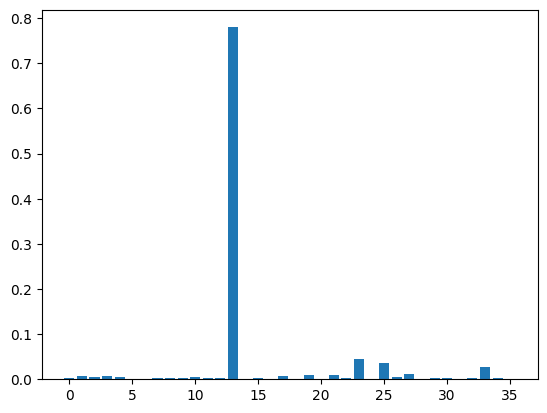

In [385]:
plt.bar(range(len(mdl_press.feature_importances_)), mdl_press.feature_importances_)
plt.show()

In [14]:
# Start doing progressive scan testing!
sim = 51

test_x = []
test_y = []

data, speed, theta = extract_and_realign(benchmark.train_dataset, sim)
parents = identify_parents(data, sim)
surface = get_surface(data)

# Build test data
for idx in tqdm(range(0, len(data))):
    test_x.append(transform_x(idx, data, parents, surface, speed, theta))
    test_y.append(transform_y(data[idx, X_VEL:], [is_surface(data[idx])]))
  

test_x = np.vstack(test_x)
test_y = np.vstack(test_y)
test_y_raw = data[:, X_VEL:]

Simulation: 51


100%|██████████| 179984/179984 [00:20<00:00, 8896.97it/s]


In [15]:
test_prog = []
testbed = np.copy(data)
testbed[:, X_VEL:] = 0.0
test_parents = parents

for idx in tqdm(range(0, testbed.shape[0])):
    # features = np.expand_dims(transform_x(idx, data, test_parents, surface, speed, theta), 0) # NOT SCANNING!!!!
    features = np.expand_dims(transform_x(idx, testbed, test_parents, surface, speed, theta), 0)

    # pred_vel_theta = mdl_vel_theta.predict(features).item()
    # pred_speed = mdl_speed.predict(features).item()
    pred_x = mdl_x.predict(features).item()
    pred_y = mdl_y.predict(features).item()
    pred_press = mdl_press.predict(features).item()
    pred_turb = mdl_turb.predict(features).item()

    # Update testbed with new predictions so they can be used as parents
    testbed[idx, X_VEL:] = untransform_y(np.array([pred_x, pred_y, pred_press, pred_turb]))
    # testbed[idx, X_VEL:] = untransform_y(np.array([pred_vel_theta, pred_speed, pred_press, pred_turb]))


100%|██████████| 179984/179984 [04:31<00:00, 661.87it/s] 


In [16]:
q = PRESS
print(np.max(testbed[:, q]))
print(np.min(testbed[:, q]))
print(np.max(data[:, q]))
print(np.min(data[:, q]))
np.argmax(abs(testbed[:, q] - data[:, q]))

2352.856
-6073.644
1313.225
-892.7455


46537

In [388]:
print(data[42912, :])
print(testbed[42912, :])

[-3.4160884e-03  1.8185653e-02  6.7464706e+01 -1.4826876e+00
  4.7652837e-04  0.0000000e+00  0.0000000e+00  4.7701380e-01
 -6.0843458e+00  2.2617151e+03  4.0738224e-13]
[-3.4160884e-03  1.8185653e-02  6.7464706e+01 -1.4826876e+00
  4.7652837e-04  0.0000000e+00  0.0000000e+00  8.9689657e-02
 -6.3022518e+00  2.2729666e+03 -1.7818913e-05]


In [27]:
for i in range(X_VEL, TURB+1):
    print(np.sqrt(mean_squared_error(testbed[:, i], data[:, i])) / np.mean(np.abs(data[:, i])))


0.41247302
1.4984853
2.633219
8.950861


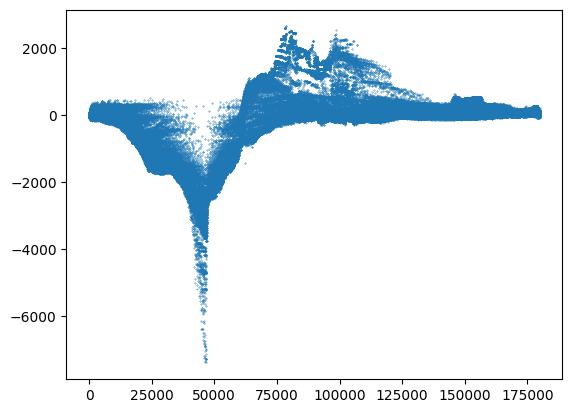

In [28]:
q = PRESS

plt.figure()
errors = testbed[:, q] - data[:, q]
plt.scatter(range(0, len(testbed)), errors, s=0.1)
plt.show()

In [325]:
print(testbed[50000, X_VEL:])
print(data[50000, X_VEL:])

[ 6.7750648e+01  1.4566237e+01 -2.5210200e+03  5.8491398e-05]
[ 2.0023332e+00 -1.6737146e+01  1.9449075e+03  2.3876699e-12]


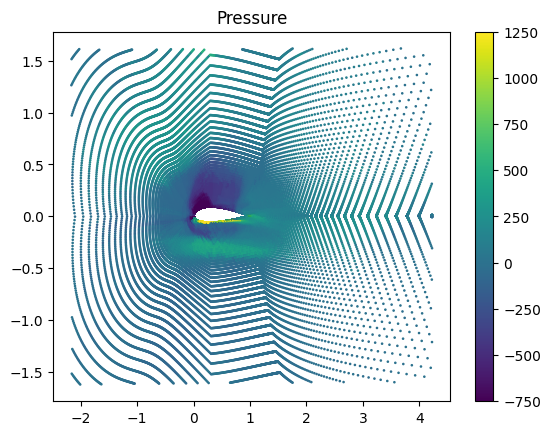

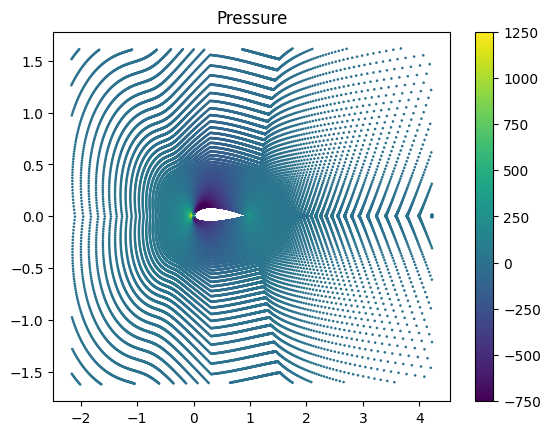

In [42]:
# fig, ax = plt.subplots(2, 2, figsize = (36, 12))
# sc0 = ax[0, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, X_VEL], s = 0.75)
# ax[0, 0].title.set_text('Velocity along x')
# plt.colorbar(sc0)
# plt.plot()
# sc1 = ax[0, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, PRESS], s = 0.75)
sc1 = plt.scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, PRESS], s = 0.75, vmin=-750, vmax=1250)
plt.title('Pressure')
# ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
# sc2 = ax[1, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, Y_VEL], s = 0.75)
# ax[1, 0].title.set_text('Velocity along y')
# plt.colorbar(sc2)
# sc3 = ax[1, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, TURB], s = 0.75)
# ax[1, 1].title.set_text('Kinematic turbulent viscosity')
# plt.colorbar(sc3)
plt.show()

# fig, ax = plt.subplots(2, 2, figsize = (36, 12))
# sc0 = ax[0, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, X_VEL], s = 0.75)
# ax[0, 0].title.set_text('Velocity along x')
# plt.colorbar(sc0)
# plt.plot()
# sc1 = ax[0, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, PRESS], s = 0.75)
sc1 = plt.scatter(data[:, 0], data[:, 1], c = data[:, PRESS], s = 0.75, vmin=-750, vmax=1250)
plt.title('Pressure')
# ax[0, 1].title.set_text('Pressure')
colorbar = plt.colorbar(sc1)
# sc2 = ax[1, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, Y_VEL], s = 0.75)
# ax[1, 0].title.set_text('Velocity along y')
# plt.colorbar(sc2)
# sc3 = ax[1, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, TURB], s = 0.75)
# ax[1, 1].title.set_text('Kinematic turbulent viscosity')
# plt.colorbar(sc3)
plt.show()

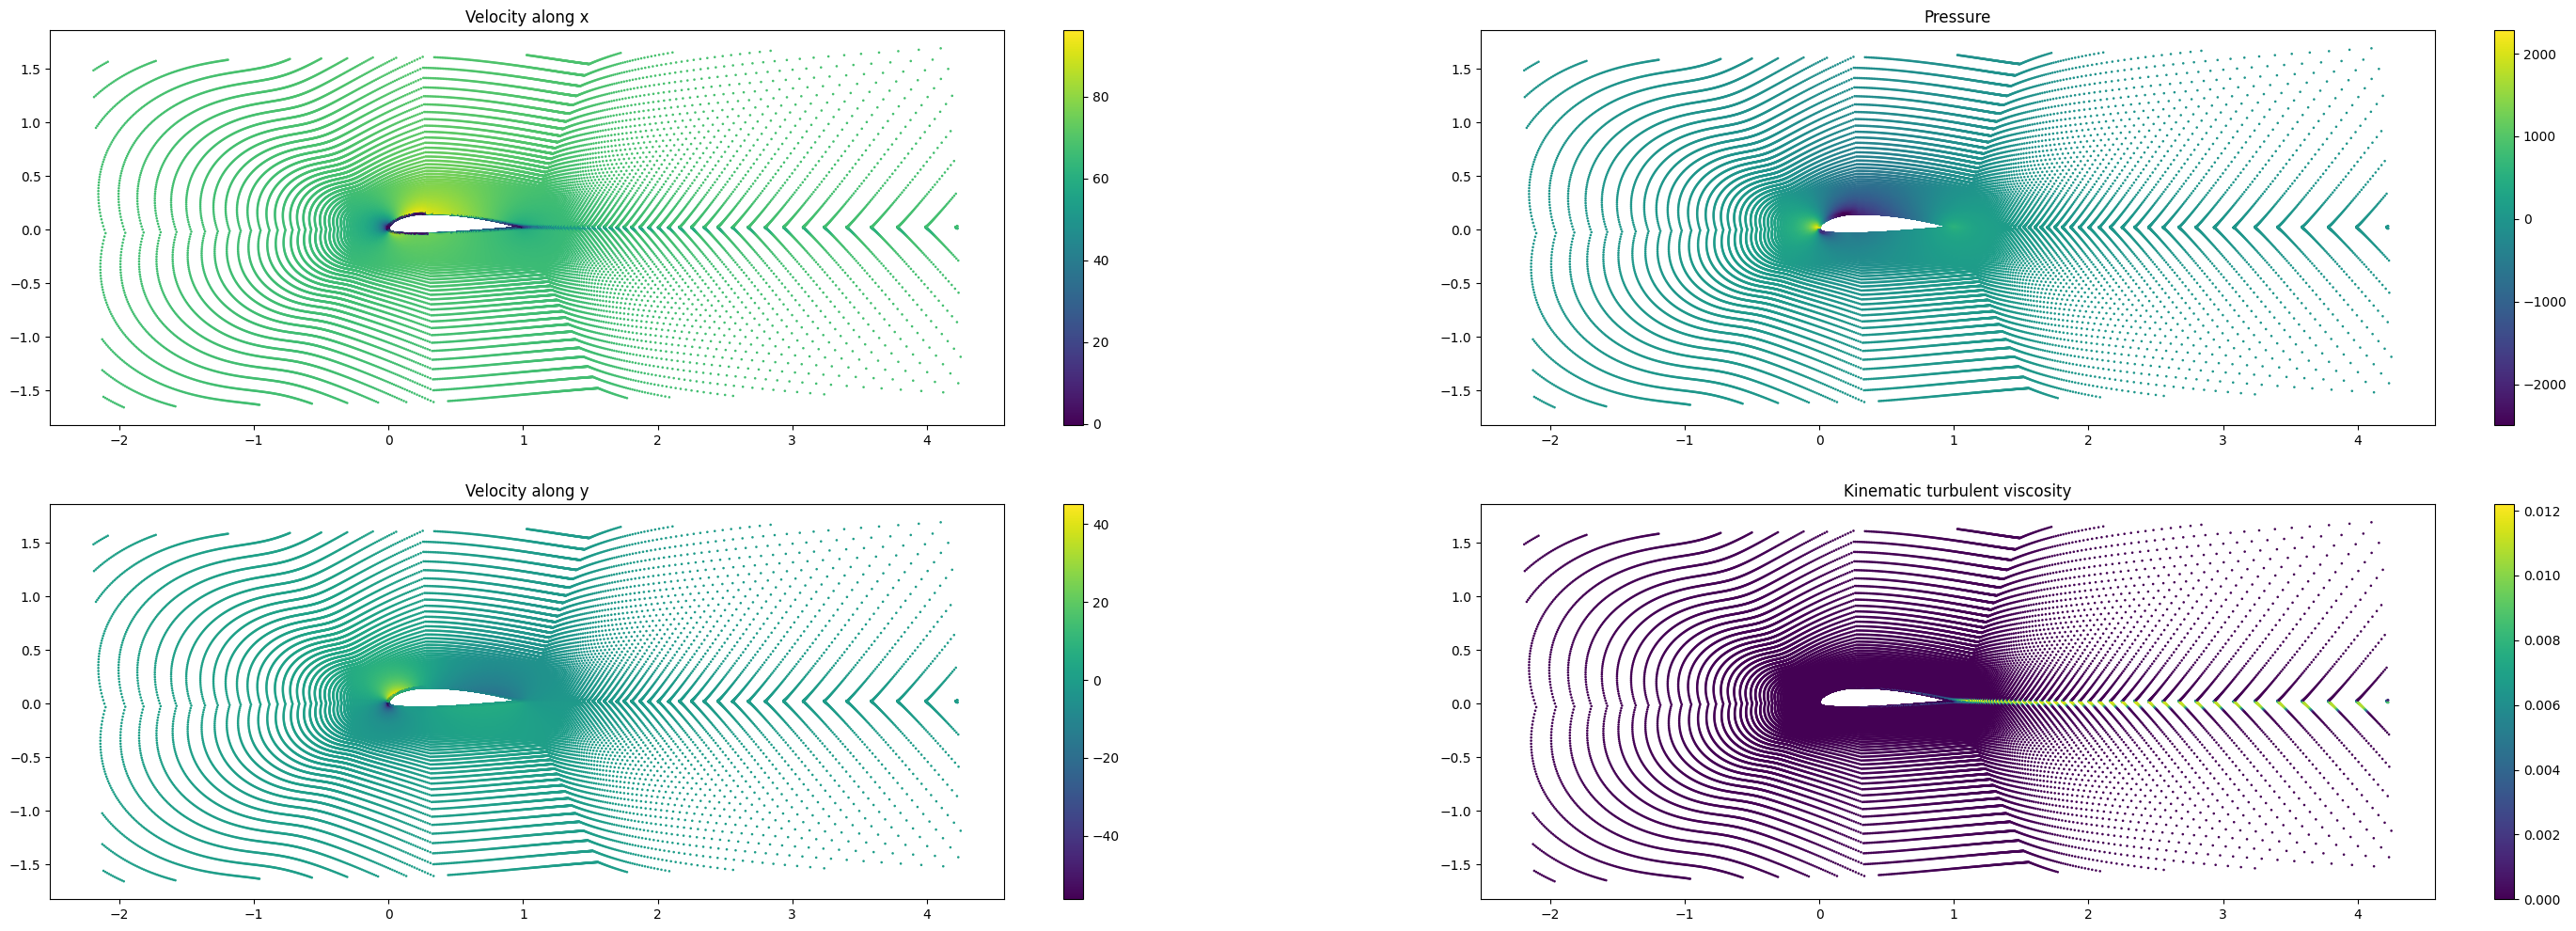

In [382]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(data[:, 0], data[:, 1], c = data[:, X_VEL], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(data[:, 0], data[:, 1], c = data[:, PRESS], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(data[:, 0], data[:, 1], c = data[:, Y_VEL], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(data[:, 0], data[:, 1], c = data[:, TURB], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

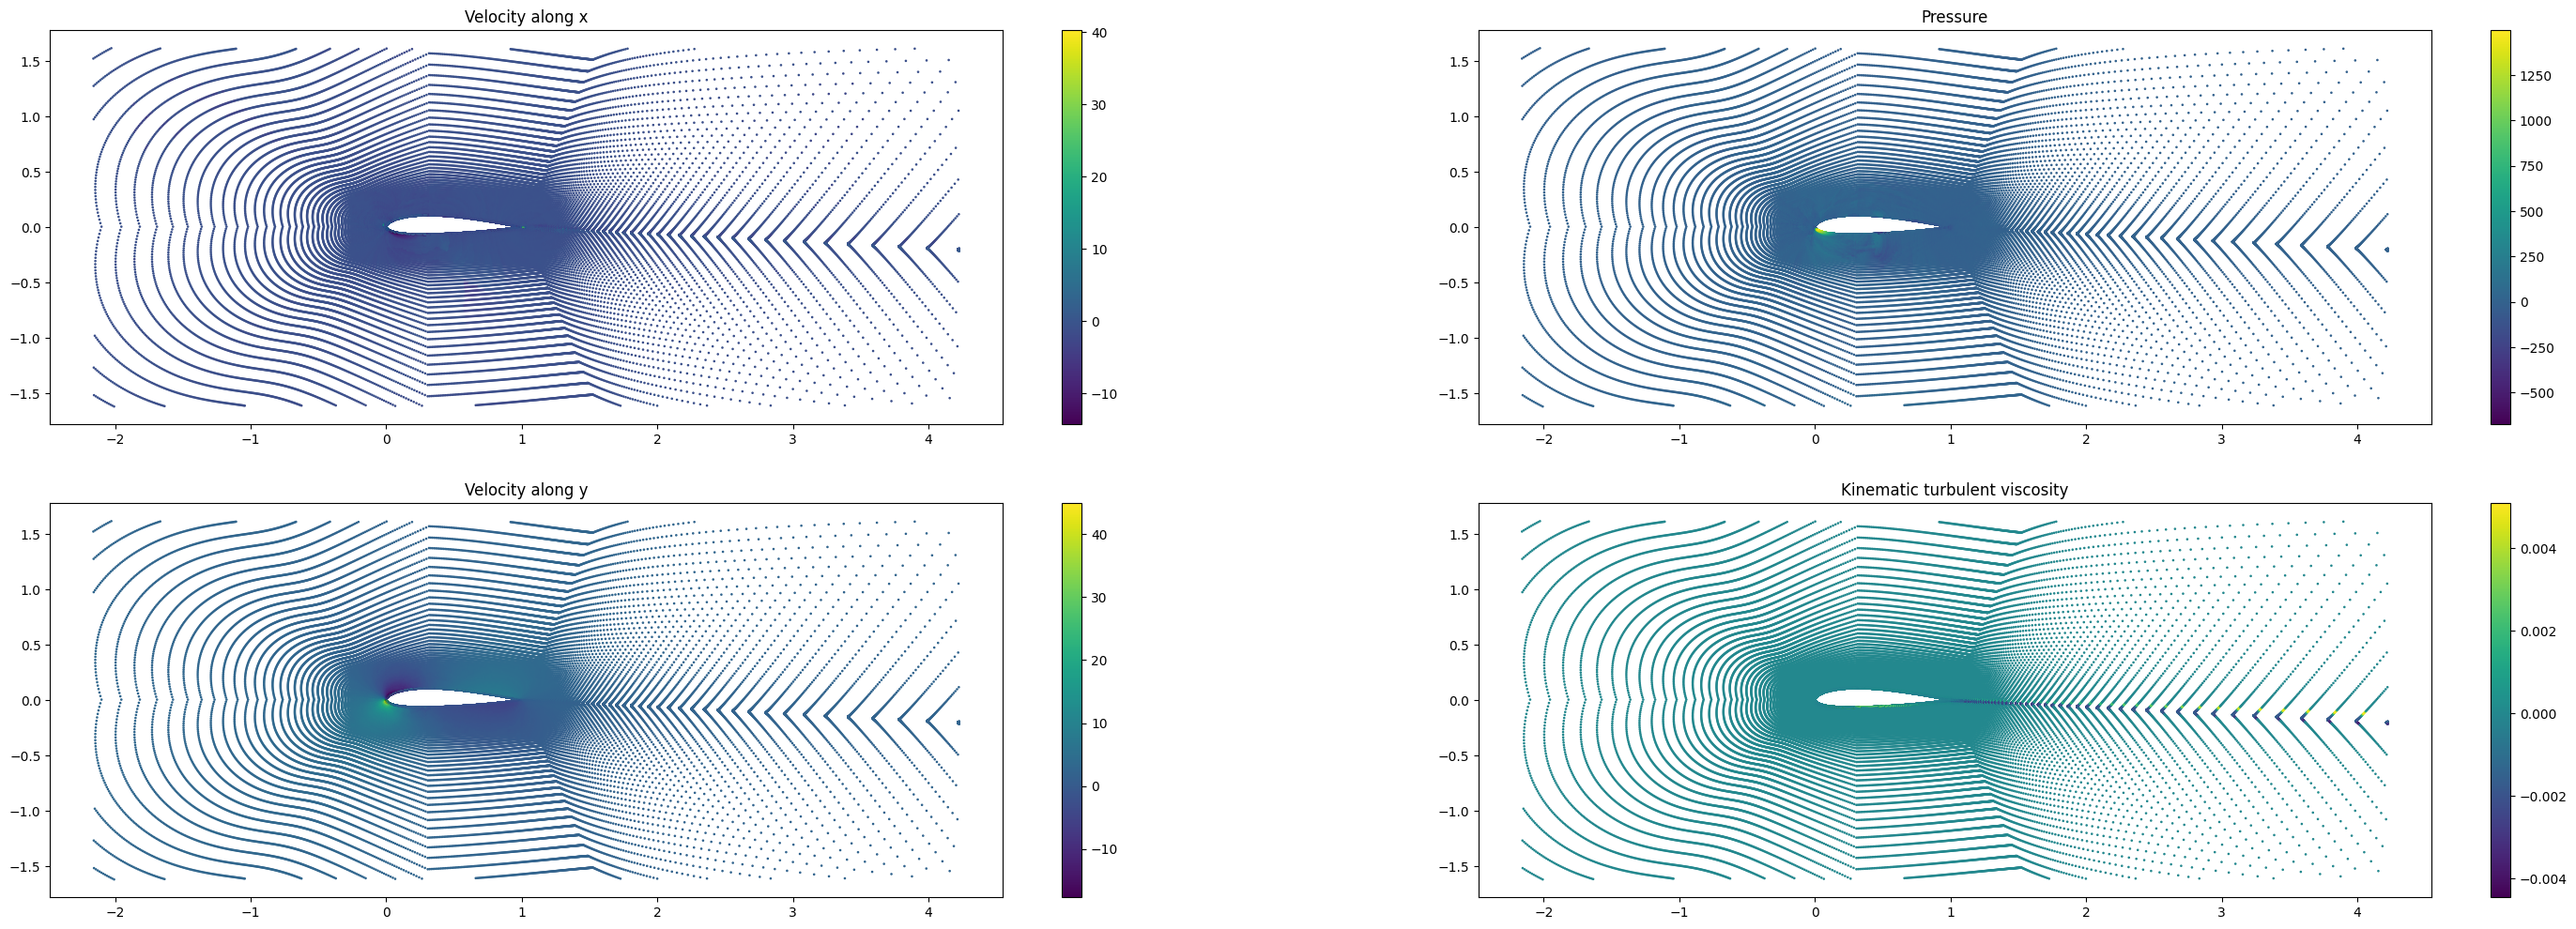

In [36]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(newtest[:, 0], newtest[:, 1], c = testbed[:, X_VEL] - newtest[:, X_VEL], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(newtest[:, 0], newtest[:, 1], c = testbed[:, PRESS] - newtest[:, PRESS], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(newtest[:, 0], newtest[:, 1], c = testbed[:, Y_VEL] - newtest[:, Y_VEL], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(newtest[:, 0], newtest[:, 1], c = testbed[:, TURB] - newtest[:, TURB], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

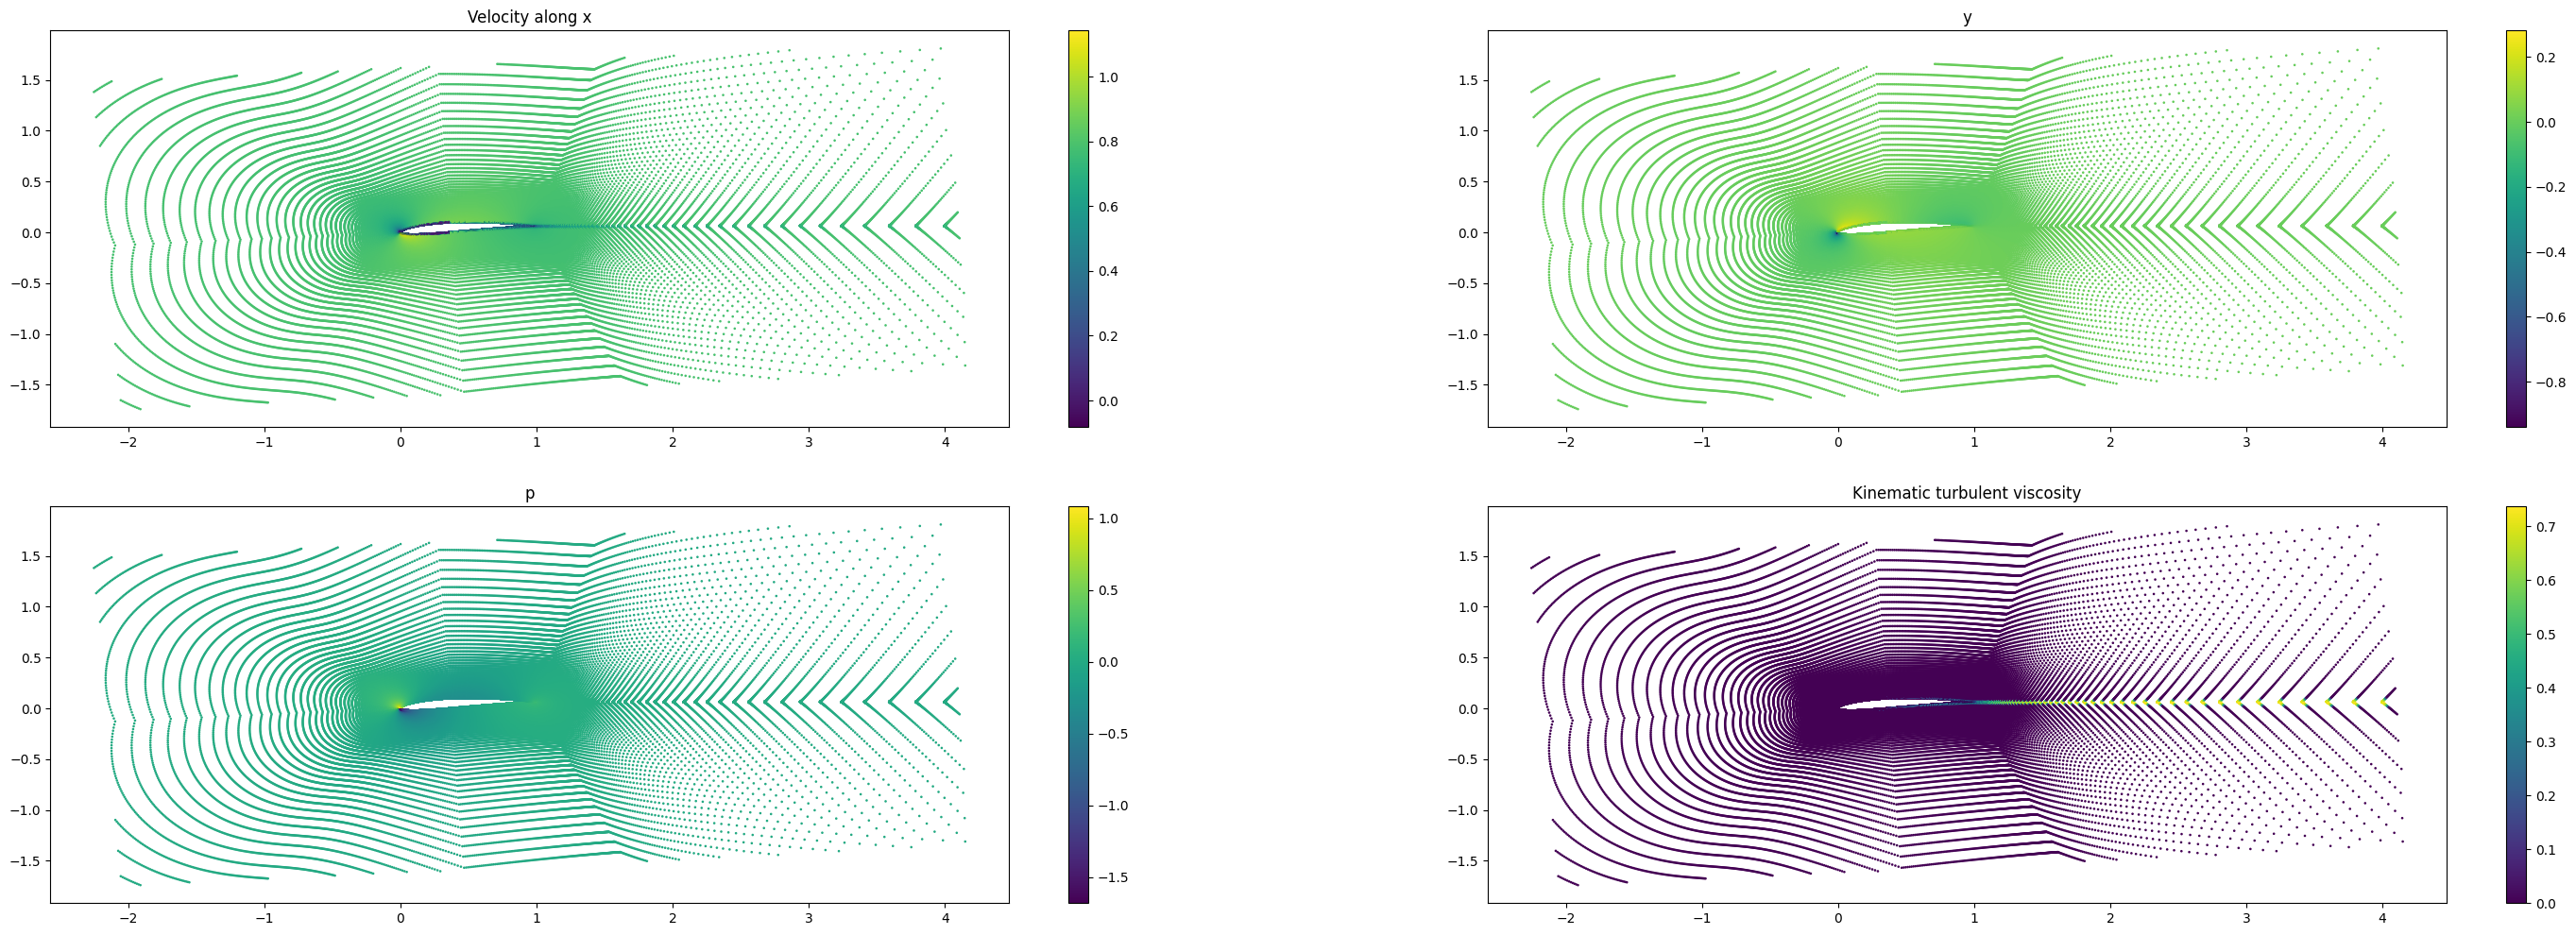

In [375]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 1], s = 0.75)
ax[0, 1].title.set_text('y')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 2], s = 0.75)
ax[1, 0].title.set_text('p')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

In [111]:
q = np.copy(testbed)
in_vector = q[0,X_INLET:Y_INLET+1]
speed = np.linalg.norm(in_vector)
in_vector /= speed
print(speed)
print(in_vector)
theta = np.arccos(np.maximum(-1, np.minimum(1,np.array([1,0]).dot(in_vector))))
if(in_vector[1] < 0): # Rotate clockwise if vector above 0
    theta = -theta

print(theta)

def rotate(point, angle):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    return point.dot(rot_matrix)

print(q[0,:2])
print(rotate(q[:,:2], theta))
q[:,:2] = rotate(q[:,:2], theta)
q[:,X_NORMAL:Y_NORMAL+1] = rotate(q[:,X_NORMAL:Y_NORMAL+1], theta)

surface = q[np.where(np.logical_or(q[:,X_NORMAL] != 0.0, q[:,Y_NORMAL] != 0.0))]

closest = surface[np.argmin(np.linalg.norm(surface[:,:2] - np.array([3, 0.0]), axis=1))]
closest[:2]

75.517
[ 0.9979893  -0.06338275]
-0.06342518852209664
[-2.160552   1.5229744]
[[-2.25273798  1.38297056]
 [-2.23525535  1.1366363 ]
 [-2.21558434  0.83650667]
 ...
 [ 4.23029477  0.05353435]
 [ 4.22935391  0.07554085]
 [ 4.23089659  0.05291324]]


array([0.9979893 , 0.06338267], dtype=float32)

In [58]:
first_ds = extract_dataset_by_simulation("BySim", benchmark.train_dataset, 0)
np.sum(first_ds.extra_data['surface'])

944.0